#### Nanosphere Sample

In [7]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os.path import isfile, join, expanduser
from os import listdir
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')
#home = r'C:/Users/Kas/Documents/GitHub/'
sys.path.append(join(home,'helpfullscripts/'))
import forJCM
import geometry_2 as geo2
#import jcm_plotting_utils as JCMgrid

jcm_root = join(home,'JCMwave/JCMsuite_6_0_10/ThirdPartySupport/Python')
#jcm_root = r'C:/Users/Kas/AppData/Roaming/JCMwave/JCMsuite/ThirdPartySupport/Python'
sys.path.append(jcm_root)
import jcmwave



sys.path.append(join(home,'XRR_workflows/calculate_n_k_from_xrr'))
import xray_compounds as xc
import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

In [2]:
#00:15:5d:0c:1d:88
#f8:e4:e3:e0:25:e5


In [2]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
        Hostname='localhost',
        #Login='andrle01',
        JCMROOT=jcm_root,
        Multiplicity=5,
        NThreads=5
        )

jcmwave.set_memory_limit(max_ram=20000)
#ssh = SSHClient()
#ssh.load_system_host_keys()
#ssh.connect('aidos')
#ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command('renice 5 -u andrle01')

In [3]:
def load_exp_data(name):
    exp_1 = pd.read_csv(name,delimiter=',')   
    exp_1_array = np.asarray(exp_1)    
    return exp_1_array

In [8]:
path = '.'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('V.csv') and f.startswith('')]
onlyfiles  

energy_list = [278.9, 284.5, 293.9, 400]
energy_list = np.asarray(energy_list)

exp_data_all = []

for i, entry in enumerate(energy_list):
    exp_data_temp = load_exp_data(onlyfiles[i])
    exp_data_all.append(exp_data_temp)

np.shape(exp_data_all[0])

(1122, 2)

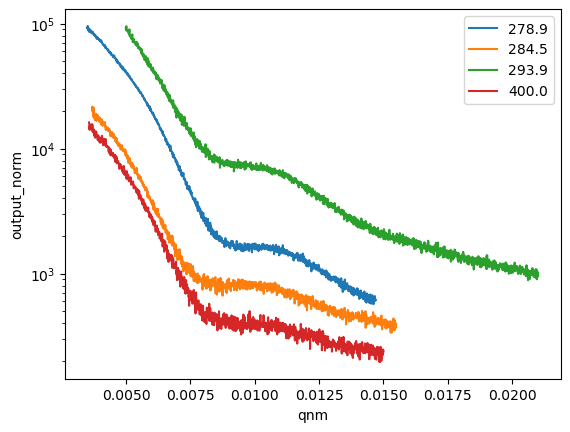

In [9]:
for i,entry in enumerate(exp_data_all):
    plt.plot(entry[:,0],entry[:,1],label=energy_list[i])
plt.xlabel('qnm')
plt.ylabel('output_norm')
plt.yscale('log')
plt.legend()

In [14]:
keys = forJCM.defkeys_680_v1()
#keys['energy_list'] = energy_list
keys['energy_list'] = np.array([278.9,284.5,293])
energy =  keys['energy_list'] * unit.eV
wl = energy.to(unit.nm, 'sp').magnitude
keys['energy'] = energy[-1].to(unit.keV, 'sp').magnitude
keys['pol'] = [0, 1] #1,0 s pol 0,1 p pol
keys['lambda'] = wl[-1] * 1e-9
keys['aoi_offset'] = 0
keys['phi_offset'] = 0

keys['scale'] = 1
nk_oleic_1 = np.conjugate(xc.refractive_index('C18H34O2', wl * unit.nm, density=2))
nk_oleic_2 = np.conjugate(xc.refractive_index('C18H34O2', wl * unit.nm, density=2))
nk_NaCl = np.conjugate(xc.refractive_index('NaCl', wl * unit.nm, density=2))

nk_oleic_1_all = pd.read_csv('oleic_dry_NEXAFS_optical_constant.csv')
#nk_NiO2_all = pd.read_excel('optical_const_for_Ni.xlsx',sheet_name=1)
f_n_oleic_1 = scipy.interpolate.interp1d(nk_oleic_1_all['Energy (eV)'],1-nk_oleic_1_all['delta'], kind='linear')
f_k_oleic_1 = scipy.interpolate.interp1d(nk_oleic_1_all['Energy (eV)'],nk_oleic_1_all['beta'], kind='linear')
#f_n_NiO2 = scipy.interpolate.interp1d(nk_NiO2_all['Energy (eV)'],1-nk_NiO2_all['delta'], kind='linear')
#f_k_NiO2 = scipy.interpolate.interp1d(nk_NiO2_all['Energy (eV)'],nk_NiO2_all['beta'], kind='linear')

nk_oleic_1 = []
#nk_NiO2 = []
for energy in keys['energy_list']:
    nk_oleic_1.append(f_n_oleic_1(energy)+f_k_oleic_1(energy)*1j)
#    nk_NiO2.append(f_n_NiO2(energy)+f_k_NiO2(energy)*1j)

keys['nk_oleic_1'] = nk_oleic_1
keys['nk_oleic_2'] = nk_oleic_2
keys['nk_NaCl'] = nk_NaCl

keys['nk'] = [1 + 0 * 1j, #vacuum
              nk_oleic_1[0], #oxide layer
              nk_oleic_2[0], #material of the grating
               nk_NaCl[0], #nk_Si3N4, #layer on top of the substrate
               1 + 0 * 1j #substrate nk_Si
             ]


keys['name_domain'] = ['vacuum','oleic_1','oleic_2','core','substrate']
keys_geo ={
    'radius_core':50,
    'radius_shell':100,
    'cd':50,
    'swa':85,
    'thickness_oxid_etch_offset':0,
    'thickness_oxid':3,
    'thickness_oxid_Si_Si3N4': 100,
    'height_offset_substrate':10,
    'height_offset_air':30,
    'R':3
    }

keys.update(keys_geo)
keys['width_cd'] = keys_geo['radius_shell']+10
keys['height_cd'] = keys_geo['radius_shell']*2+10
keys['MaximumSideLength'] = 1*keys['lambda']*1e9

keys['points_substrate'], keys['points_line_komplet'], keys['points_oxid_komplet'], keys[
        'points_cd'], keys["points_to_Si_Si3N4"] = geo2.geometry(keys['cd'], keys['R'], keys['thickness_oxid'],
                                                                 keys['swa'], keys['pitch'], keys['height'],
                                                                 keys['height_offset_substrate'],
                                                                 keys['thickness_oxid_Si_Si3N4'],
                                                                 keys['height_etch_offset'],
                                                                 keys['thickness_oxid_etch_offset'],
                                                                 keys['height_offset_air'])
angles = np.linspace(-120,-90,51)
keys['Theta_unique'] = angles
keys['angles'] = []
for entry in keys['Theta_unique']:
    keys['angles'].append([180+entry,0.])

#keys['angles'] = np.array([
##    [3.,0.],
#    [180+89,0.],
#    [180+45.,0.],
#   [180.,0.],
##    [18.,0.],
#    #[21.,0.]
#])
    
#keys['exp_data_all'] = np.asarray(exp_data_all)

#keys['slc'] = 0.8
#keys['fem_deg'] = 4

#keys['points_line_komplet'][5:19:2] += 20
#keys['points_line_komplet'][-13::2] += 20
#keys['points_oxid_komplet'][5:19:2] += 20
#keys['points_oxid_komplet'][6:18:2] -= 20
#keys['points_oxid_komplet'][-13::2] += 20


Standard Keys for E=680eV


In [34]:
keys['lambda']

4.231542608641647e-09

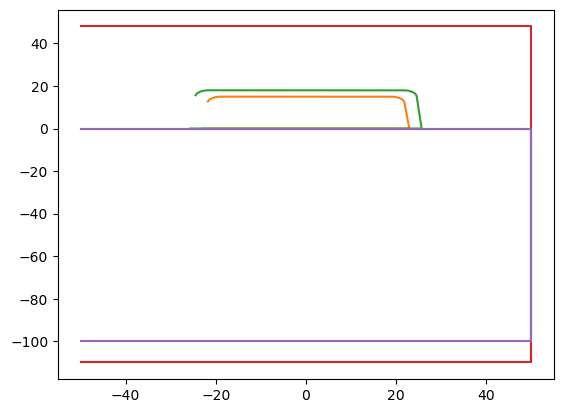

In [6]:


plt.plot(keys['points_substrate'][::2],keys['points_substrate'][1::2])
plt.plot(keys['points_line_komplet'][::2],keys['points_line_komplet'][1::2],'-')
plt.plot(keys['points_oxid_komplet'][::2],keys['points_oxid_komplet'][1::2])
plt.plot(keys['points_cd'][::2],keys['points_cd'][1::2])
plt.plot(keys['points_to_Si_Si3N4'][::2],keys['points_to_Si_Si3N4'][1::2])

In [15]:
jcmwave.geo('./_JCMupdate/', keys=keys )
#figure,ax1 =plt.subplots(1,1, figsize=(5,10))
#JCMgrid.plot_grid('./_JCMupdate/grid.jcm', ax= ax1 , colors = {1: 'white', 2:'green', 3: 'black', 4:'orange', 5:'blue', 6:'green'}, alpha= 0.5 , lw = 0.2)
#jcmwave.view('./_JCMupdate/grid.jcm')

In [16]:
keys['angle_of_incidence'] = 0 #+Theta_unique[30] #keys['angles'][10][0] #90-keys['angles'][0][0]+keys['aoi_offset'] +180
#print(Theta_unique[30])

keys['phi'] = 0 #90 +keys['angles'][0][1]+keys['phi_offset']  #
#keys['slc'] = 0.8
#keys['fem_deg'] = 4
        
#jcmwave.daemon.shutdown()
result = jcmwave.solve('./_JCMupdate/project.jcmpt',  keys=keys,temporary=True)
results, logs = jcmwave.daemon.wait(result,verbose=False)

In [12]:
results[0][-1]

{'field': [array([[[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]],
  
         [[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]],
  
         [[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]],
  
         ...,
  
         [[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]],
  
         [[0.+0.j, 0.+0.j, 0.+0.j]

In [17]:
result = results[0]

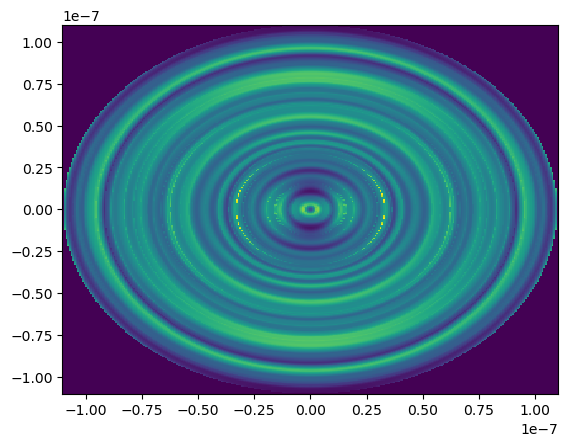

In [18]:
index_take = -1
amplitude = results[0][index_take]['field'][0]
intensity = (amplitude.conj()*amplitude).sum(2).real 

#intensity = np.absolute(result[4]['field'][0])
#np.shape(result[4]['X'])
np.shape(intensity)
#intensity
plt.pcolormesh(results[0][index_take]['X'],results[0][index_take]['Z'],intensity)

(212281,)


/tmp/ipykernel_2346516/2279245119.py:18: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(grid_x, grid_y, np.log(grid_z))


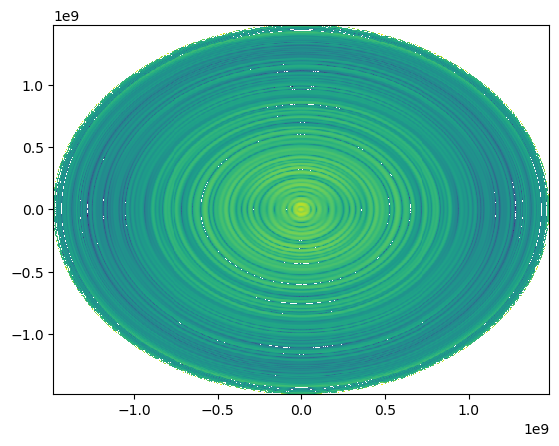

In [19]:
#print(result[1].keys())
#np.shape(result[1]['K'])
Kx = result[1]['K'][:,0]
Kz = result[1]['K'][:,2]

amplitude_x = result[1]['ElectricFieldStrength'][0][:,0]
amplitude_y = result[1]['ElectricFieldStrength'][0][:,1]
amplitude_z = result[1]['ElectricFieldStrength'][0][:,2]
intensity = (amplitude_x.conj()*amplitude_x).real +(amplitude_y.conj()*amplitude_y).real +(amplitude_z.conj()*amplitude_z).real 

print(np.shape(Kx))
np.shape(intensity)


grid_x, grid_y, grid_z = forJCM.interpolate_map(Kx, Kz, intensity)
   
#plt.plot(result[1]['K'][:,2],result[1]['ElectricFieldStrength'][0][:,2])
plt.pcolormesh(grid_x, grid_y, np.log(grid_z))

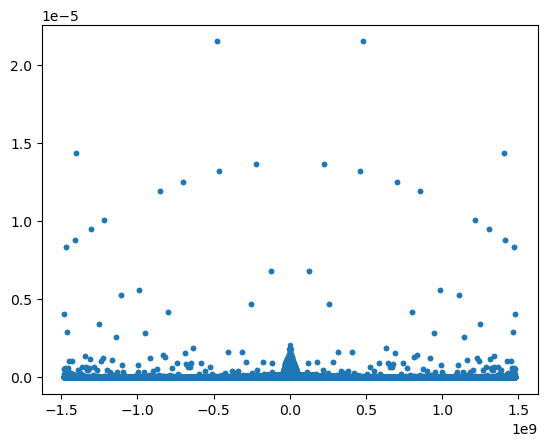

In [20]:
plt.plot(Kx, intensity,'.')

In [62]:
jcmwave.view('./_JCMupdate/project_results/fieldbag.jcm')
#jcmwave.geo(path,keys=keys)


In [20]:
def objective_JCMopt(return_scales=False,do_cor=False, **kwargs):
    keys.update(kwargs)
    keys['points_substrate'], keys['points_line_komplet'], keys['points_oxid_komplet'], keys[
        'points_cd'], keys["points_to_Si_Si3N4"] = geo2.geometry(keys['cd'], keys['R'], keys['thickness_oxid'],
                                                                 keys['swa'], keys['pitch'], 
                                                                 keys['height'],
                                                                 keys['height_offset_substrate'],
                                                                 keys['thickness_oxid_Si_Si3N4'],
                                                                 keys['height_etch_offset'],
                                                                 keys['thickness_oxid_etch_offset'],
                                                                 keys['height_offset_air'])
    
    

    
    job_ids = []

    #for n in range(len(keys['angles'])):
    for energy in keys['energy_list']:
        x_energy = np.where(keys['energy_list']==energy)[0][0]

        keys['energy'] = energy*1e-3 #[x_energy].to(unit.keV, 'sp').magnitude
            #print(keys['energy'])
        keys['lambda'] = wl[x_energy] * 1e-9


        keys['nk'] = [1 + 0 * 1j, #vacuum
                keys['nk_NiO2'][x_energy], #oxide layer
                keys['nk_Ni'][x_energy], #material of the grating
                keys['nk_Si3N4'][x_energy], #nk_Si3N4, #layer on top of the substrate
                1 + 0 * 1j #substrate nk_Si
                ]
        for theta in keys['Theta_unique']:
            keys['angle_of_incidence'] = 180+theta+keys['aoi_offset']#90-keys['angles'][n][0]+keys['aoi_offset']
            keys['phi'] = 90+keys['phi_offset']  #

            
        
            

            job_id = jcmwave.solve('./_JCMupdate/project.jcmpt',
                                        keys=keys,
                                        #logfile=open(os.devnull, 'w'),
                                        temporary=True
                                        )
            job_ids.append(job_id)
        
    results, logs = jcmwave.daemon.wait(job_ids,verbose=False)
    #results = job_ids
    
    sigma = np.square(2)
    fem_int_rough_all = []
    fem_int_all = []
    orders_all = []
    chi_all = []
    angles_out = []
    chi_sum = 0
    for i,result in enumerate(results):
        try:
            result = result[-1]
        except:
            print(logs)
        orders = result['N1'] * -1
        #print(result)
        zero_order = np.where(orders == 0)
        k_input = result['K'][zero_order, :]
        cos_theta_in = np.abs(k_input[0][0][1]) / np.linalg.norm(k_input)
        cos_theta_out = result['K'][:, 1] / np.linalg.norm(k_input)
        fem_int = np.square(np.absolute(result['ElectricFieldStrength'][0][:, -1]))# ** 2
        #print(result['ElectricFieldStrength'][0][:, -1])
        phi_out = np.rad2deg(np.arcsin((np.absolute(result['K'][:, 0]) / np.linalg.norm(k_input))))
        fem_int_cor = fem_int * (cos_theta_out / cos_theta_in) * np.cos(np.deg2rad(phi_out))
    
        keys['fem_kx'] = result['K'][:, 0][1]*1e-9 
        kx = keys['fem_kx']
        
        kx_sq = np.square(kx)
        fem_int_rough = fem_int_cor * np.exp(-sigma * kx_sq) 
    
        fem_int_rough_all.append(fem_int_rough * keys['scale'])
        fem_int_all.append(fem_int * keys['scale'])
        orders_all.append(orders)
        angles_out.append([cos_theta_out,phi_out])
    
        #x_exp = []
        #bad_entry = []
        #exp_data_angle = str(keys['angles'][i][0])
        #print('angle',exp_data_angle)
        #print(exp_data[exp_data_angle][0])
        #print(orders)
        #for ii, entry in enumerate(exp_data[exp_data_angle][0]):
        #    try:
        #        x_exp.append(np.where(orders == entry)[0][0])
        #    except:
        #        bad_entry.append(exp_data_angle)
        #        bad_entry.append(entry)
        #if do_cor:
        #    chi = np.square(exp_data[exp_data_angle][1] - fem_int_rough[x_exp] ) / np.square(np.asarray(exp_data[exp_data_angle][1])*0.01) #maybe do the log here
        #else:
       #     chi = np.square(exp_data[exp_data_angle][1] - fem_int[x_exp] ) / (np.square(np.asarray(exp_data[exp_data_angle][1])*0.01) + np.square(1e-5)) #maybe do the log here
        #chi = chi/len(chi)
        #chi = 1
        #chi_all.append(chi)
        #chi_sum += np.sum(chi)
        
    orders_unique=np.unique(exp_data_all['Order'])
    orders_unique
    kk = 0

    for energy in keys['energy_list']:
        for theta in keys['Theta_unique']:
            orders_temp = np.asarray(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)]['Order'])
            indices = [np.where(orders_all[kk]==x)[0][0] for x in orders_temp]
            for ii,order in enumerate(orders_temp):
                exp_data_all.loc[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)&(exp_data_all['Order']==order),'Intensity_calc'] = fem_int_all[kk][indices[ii]] 
            kk += 1
       
    exp_data_temp = np.asarray(exp_data_all['Intensity'])*1e-7
    fit_data_temp = np.asarray(exp_data_all['Intensity_calc'])
    sigma_sq = np.square(0.05*exp_data_temp)+np.square(0.9*np.min(np.abs(exp_data_temp)))
    scale_p = 1
    chi_fun = lambda scale: np.sum(np.square(exp_data_temp - (scale*fit_data_temp))  / sigma_sq)
    res = scipy.optimize.minimize_scalar(chi_fun, bounds=(1-scale_p, 100+scale_p), args=(), method='Bounded',
                                   options={'xatol': 1e-05})
    scale = res.x
    chi_sum = chi_fun(scale)
    
    if return_scales: return fem_int_all, fem_int_rough_all,orders_all, chi_all, chi_sum,angles_out,scale
   
    observation = study.new_observation()
    #we minimize just chi² since np.sum(np.log(1 / (np.sqrt(2 * np.pi * sigma_N/O)))) is constant
    #observation.add(np.log(chi_N + chi_O))
    observation.add((chi_sum)) #!!!!!!!!!try log here
    #observation.add((chi_N))
    #observation.add(-llike_N - llike_O)
    
    
    return observation      


In [46]:
np.sum(np.asarray(exp_data_all['Intensity']-exp_data_all['Intensity_calc']))


scale_p = 0.25
    chi_N_fun = lambda scale_N: np.sum(np.square(keys['exp_data_N'] - (scale_N*normJCM_N))  / sigma_N)# + np.sum(np.square(keys['exp_data_O'] - (scale_N*normJCM_O))  / sigma_O)
    #res = scipy.optimize.minimize_scalar(chi_N_fun, bounds=(1-scale_p, 1+scale_p), args=(), method='Bounded',
    #                               options={'xatol': 1e-05})
    
    scale_N = keys['scale_N']#res.x
    #scale_N = 1
    #print('scale_N = {}'.format(scale_N))
    chi_N = chi_N_fun(scale_N)
 

90041.02042561199

In [26]:
fem_int_all, fem_int_rough_all,orders_all, chi_all, chi_sum,angles_out,scale = objective_JCMopt(return_scales=True,**keys)

keys['fem_int_all'] = fem_int_all
keys['fem_int_rough_all'] = fem_int_rough_all
keys['orders_all'] = orders_all
keys['chi_all'] = chi_all
keys['chi_sum'] = chi_sum
keys['angles_out'] = angles_out


with open('saved_calculation_udnk_h15_phi0_pol01_toffset_0.pkl', 'wb') as f:
    pickle.dump(keys, f)
        
#with open('saved_dictionary.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

scale

2.4584150668730822e-05

In [66]:
scale

3.566698083379131e-05

In [7]:
keys_geo ={
    'pitch':100,
    'height':17,
    'cd':50,
    'swa':85,
    'thickness_oxid_etch_offset':3,
    'thickness_oxid':3,
    'thickness_oxid_Si_Si3N4': 100,
    'height_offset_substrate':10,
    'height_offset_air':30,
    'R':3
    }


domain = [        
        {'name': 'height', 'type': 'continuous', 'domain': (10,25)},        
        {'name': 'cd', 'type': 'continuous', 'domain': (40, 60)},
        {'name': 'swa', 'type': 'continuous', 'domain': (80, 90)},
        {'name': 'aoi_offset', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'phi_offset', 'type': 'continuous', 'domain': (0,90)},
        {'name': 'scale', 'type': 'fixed', 'domain': 1},  
    ]
#constraints = [
#    {'name':'height_constraint', 'constraint': 'point_4 - height'},
#    {'name':'point_4_constraint', 'constraint': 'point_3 - point_4'},
#    {'name':'geo_constraint', 'constraint': 'abs(point_2) - abs(point_3)'},
#    {'name':'point_2_constraint', 'constraint': 'abs(point_1) - abs(point_2)'},
#    {'name':'point_1_constraint', 'constraint': 'abs(point_0) - abs(point_1)'},
#    {'name':'sidewall_cd_height_relation', 'constraint': '-0.5*(cd - height * tan(swa*Pi/180.))'}
#]
#0.5 * keys['cd'] + (keys['height'] / 2) * np.tan(np.deg2rad(90 - keys['swa']))
study = jcmwave.optimizer.create_study(domain=domain, name='BO', #constraints=constraints,
                                       study_id='BO_Scattering_Ni_02',
                                       #save_dir=join(home,'NextCloud/Si3N4/Si3N4_p100h90w50/')#,
                                       save_dir='/pscratch/sd/k/kandrle/tmp/',
                                       #driver= 'DifferentialEvolutionOptimization', #'L_BFGS_B_Optimization',#'DifferentialEvolutionOptimization', #'ParticleSwarmOptimization'
                                       dashboard = False,
                                       open_browser = False
                                      )
                                       #driver='ParticleSwarmOptimization')
    




In [ ]:
#jcmwave.set_memory_limit(max_ram=3000)
study.set_parameters(max_iter=6000, num_parallel=1)
study.set_objective(objective_JCMopt)
study.run()

2024-02-02 17:03:59: Computing 1-th evaluation.
2024-02-02 17:03:59: Calculated sample [23.0743, 46.0018, 85.927, -0.0556442, 60.604] in 0.001289 s.


In [9]:
study.info()['min_params']

{'height': 10.0,
 'cd': 43.7178763316,
 'swa': 88.1211117738,
 'aoi_offset': 0.9911087366,
 'phi_offset': 77.7436683333,
 'scale': 1}

In [10]:
keys.update(study.info()['min_params'])
fem_int_all, fem_int_rough_all,orders_all, chi_all, chi_sum,angles_out,scale = objective_JCMopt(return_scales=True,**keys)

keys['fem_int_all'] = fem_int_all
keys['fem_int_rough_all'] = fem_int_rough_all
keys['orders_all'] = orders_all
keys['chi_all'] = chi_all
keys['chi_sum'] = chi_sum
keys['angles_out'] = angles_out


with open('saved_calculation_udnk_BO_Scattering_Ni_02.pkl', 'wb') as f:
    pickle.dump(keys, f)

In [7]:
with open('saved_calculation_h15_phi3_pol11.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    
keys.update(loaded_dict)

fem_int_all = keys['fem_int_all']
fem_int_rough_all =keys['fem_int_rough_all'] 
orders_all = keys['orders_all']

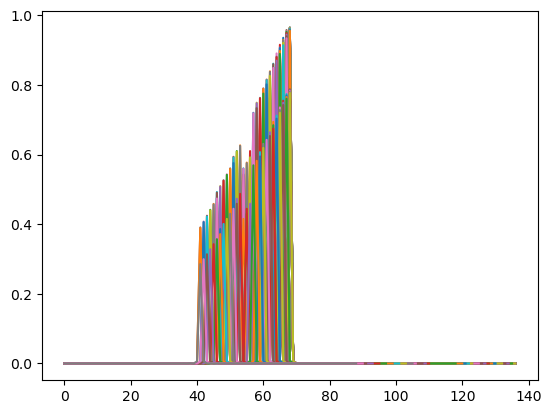

In [41]:
for entry in fem_int_all:
    plt.plot(entry)

In [8]:
exp_data_all.dtypes



array([1., 2., 3., 4., 5., 6.])

In [27]:
i = 0
orders_unique=np.unique(exp_data_all['Order'])
orders_unique

for energy in keys['energy_list']:
    for theta in Theta_unique:
        #print(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)])
        orders_temp = np.asarray(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)]['Order'])
        #try: 
        indices = [np.where(orders_all[i]==x)[0][0] for x in orders_temp]
        for ii,order in enumerate(orders_temp):
                #exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)&(exp_data_all['Order']==order)]['Intensity_calc'] = fem_int_all[i][indices[ii]]*1e15
                #print(fem_int_all[i][indices[ii]])
            exp_data_all.loc[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)&(exp_data_all['Order']==order),'Intensity_calc'] = fem_int_all[i][indices[ii]]
            #exp_data_all.loc[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==-theta)&(exp_data_all['Order']==order),'Intensity_calc'] = fem_int_all[i][indices[ii]]
        #except:
        #    print("not enough order")
            
            #print(exp_data_all.loc[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)&(exp_data_all['Order']==order)]['Intensity_calc'])
            #print(exp_data_all[exp_data_all.loc[(exp_data_all['Energy']== energy)&(exp_data_all['Theta']==theta)&(exp_data_all['Order']==order)]])
        #print(orders_temp)
        #print(orders_all[i])
        #print([np.where(orders_all[i]==x)[0][0] for x in orders_temp])
        i += 1

In [28]:
exp_data_all.to_csv('all_exp_and_calc_udnk_h15_phi0_pol01_toffset_0.txt')

In [24]:
exp_data_all

,Energy,Order,Theta,Intensity,Intensity_calc
0,850.0,1.0,-50.0,2379.907858,-0.0
1,850.0,1.0,-49.0,1927.480449,-0.0
2,850.0,1.0,-48.0,1903.532123,-0.0
3,850.0,1.0,-47.0,1591.723614,-0.0
4,850.0,1.0,-46.0,1337.627483,-0.0
...,...,...,...,...,...
31,854.2,5.0,-9.0,0.032512,0.0
32,854.2,5.0,-8.0,0.040887,0.0
33,854.2,5.0,-7.0,0.040529,0.0
34,854.2,5.0,-6.0,0.035786,0.0


In [14]:
#print(np.argmax(exp_data_all['Intensity_calc']))
#print(np.argmax(exp_data_all['Intensity']))
#print(exp_data_all.iloc[[731]])
#print(exp_data_all.iloc[[521]])
scale_calc = 1#float(exp_data_all.iloc[[731]]['Intensity_calc'])
scale_exp = 1e7#float(exp_data_all.iloc[[521]]['Intensity'])
print(scale_exp)

10000000.0


In [ ]:
for energy in keys['energy_list']:
    for order in orders_unique:

        fig = plt.figure(1, figsize=(6,6))
        fig.suptitle('E / eV = '+str(energy)+'\n order = '+str(int(order)), fontsize=12)
        ax = fig.add_subplot(111)
        ax.plot(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Theta'],exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Intensity_calc']/scale_calc,'.')
        ax.set_xlabel('Theta / deg')
        ax.set_ylabel('Calculated values')
        ax.set_yscale('log')
        #ax.set_xlim(0,35)
        ax2 = ax.twinx()

        ax2.plot(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Theta'],exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Intensity']/scale_exp,'k.')
        ax2.set_ylabel('exp data')
        ax2.set_yscale('log')

        #ax.set_ylim(ymax=y2max)
        #ax2.set_ylim(ymax=4.2*y2max)
        #plt.plot(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Theta'],exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Intensity_calc'],'.')
        #plt.plot(exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Theta'],exp_data_all[(exp_data_all['Energy']== energy)&(exp_data_all['Order']==order)]['Intensity']*10e-12,'.')
    #plt.yscale('log')
    #plt.ylim(1e-14,1e-6)
        #plt.savefig(str(energy)+str(order)+'.png', format='png', bbox_inches="tight")
        plt.show()

In [28]:
order1 = []
order2 = []
order3 = []
orders = [order1,order2,order3]
orders_rough = [order1,order2,order3]
for i,entry in enumerate(orders_all):
    entry = np.asarray(entry)
    fem_int = np.asarray(fem_int_all[i])
    fem_int_rough = np.asarray(fem_int_rough_all[i])
    entry_temp = entry[np.where(entry)]
    #print(i)
    for j in range(3):
        
        x_temp = np.where(entry == j)
        #print(fem_int[x_temp])
        try:
            orders[j].append(fem_int[x_temp][0])
            orders_rough[j].append(fem_int_rough[x_temp][0])
        except:
            orders[j].append(np.nan)
            orders_rough[j].append(np.nan)

In [19]:
np.shape(Theta_unique)
Theta_all = np.append(Theta_unique,Theta_unique)
Theta_all = np.append(Theta_all,Theta_unique)
np.shape(orders[0][::2])
keys['angles_out']

[[array([0.17508784, 0.26610967, 0.33127511, 0.38398213, 0.42884914,
         0.4681358 , 0.50315097, 0.53473443, 0.56346353, 0.58975557,
         0.61392372, 0.63621009, 0.65680625, 0.67586675, 0.69351821,
         0.70986575, 0.72499758, 0.73898839, 0.75190187, 0.76379266,
         0.77470786, 0.78468819, 0.7937689 , 0.80198055, 0.80934961,
         0.81589889, 0.821648  , 0.82661365, 0.83080986, 0.83424827,
         0.8369382 , 0.83888686, 0.84009941, 0.84057902, 0.84032696,
         0.83934257, 0.83762326, 0.8351645 , 0.83195973, 0.82800029,
         0.82327528, 0.81777144, 0.81147293, 0.80436107, 0.79641407,
         0.78760666, 0.77790962, 0.7672892 , 0.75570649, 0.74311649,
         0.72946704, 0.71469745, 0.69873669, 0.68150107, 0.66289116,
         0.64278761, 0.62104538, 0.5974856 , 0.57188369, 0.54395139,
         0.51330838, 0.4794352 , 0.44158913, 0.39864025, 0.34870813,
         0.28818555, 0.20802571, 0.04763103]),
  array([55.30069661, 52.87817733, 50.58408932, 48.39675

In [29]:
orders

[[0.25423347103145966,
  1.732653726741359e-08,
  0.2577933062492953,
  1.2708904555035847e-08,
  0.2612025208148095,
  9.220823077711888e-09,
  0.2644714401119406,
  6.6172758273960995e-09,
  0.2676052695860284,
  4.6968919441172e-09,
  0.2706103799942978,
  3.297155476521331e-09,
  0.2734890307786971,
  6.633605317165847e-09,
  0.2762491412280135,
  4.6062048836764525e-09,
  0.2788983700370272,
  3.163322399427357e-09,
  0.2814143198555782,
  2.148238149928555e-09,
  0.28385367389690797,
  1.4428325644948394e-09,
  0.2861931681147219,
  9.58246152678354e-10,
  0.288434141147293,
  1.8972968623868637e-09,
  0.29058098324682524,
  1.2473638299919112e-09,
  0.2926362475615824,
  8.109264821942195e-10,
  0.2946072018198,
  5.212981795926299e-10,
  0.2964970855509765,
  1.0184883744167562e-09,
  0.29830490733819226,
  6.485271815218621e-10,
  0.30002982320780475,
  4.0834063624385986e-10,
  0.3016823467846406,
  2.5423625888116045e-10,
  0.3032596527513628,
  4.916511509186357e-10,
  0.30

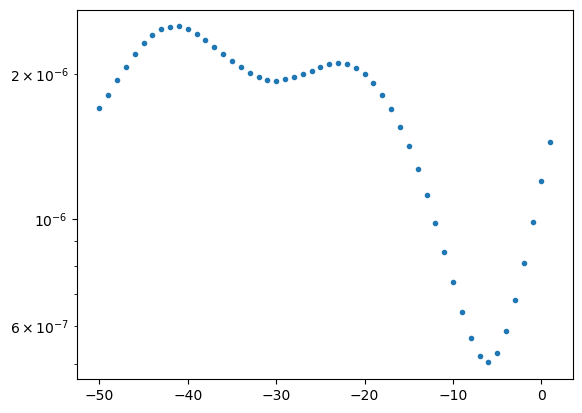

In [34]:
np.shape(np.asarray(orders))
#plt.plot(Theta_all,orders[0][::2])
plt.plot(Theta_unique,orders[2][::2],'.')
#plt.plot(keys['angles_out'],orders[2][::2])

#plt.plot(keys['angles_out'],orders_rough[0][::2])
#plt.plot(keys['angles_out'],orders_rough[1][::2])
#plt.plot(keys['angles_out'],orders_rough[2][::2])
#plt.ylim(1e-17,1e-12)

plt.yscale('log')

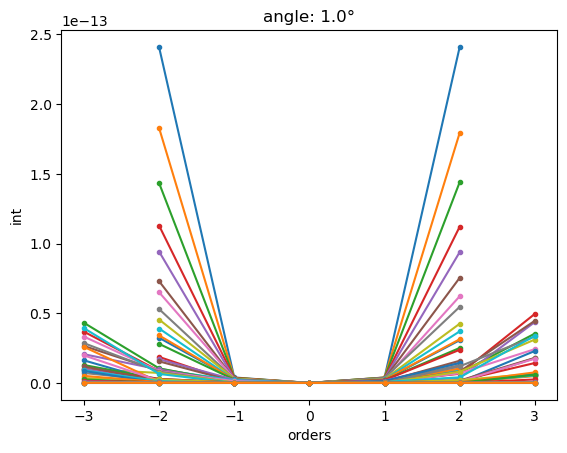

In [46]:
for n in range(len(Theta_unique)):
    exp_data_angle = str(Theta_unique[n])
    
    #plt.plot(exp_data[exp_data_angle][0],exp_data[exp_data_angle][1],'.-',label = 'Exp data')
    plt.plot(orders_all[n],fem_int_all[n],'.-',label='JCM calc')
    plt.title('angle: ' + exp_data_angle + '°')
    #plt.xlim((np.min(exp_data[exp_data_angle][0])-0.5,np.max(exp_data[exp_data_angle][0])+0.5))
    #plt.yscale('log')
    plt.xlabel('orders')
    plt.ylabel('int')
    #plt.legend()
    #plt.savefig(exp_data_angle+'.png',dpi=200)
    #plt.show()

In [8]:
#  40x Si = 4.1nm, Mo=2.8nm
#thick_Ru :  2.8683959512802173
#thick_Si :  4.142938656923797
#thick_Mo :  1.786533741547676
#thick_MoSi :  0.5236428180556649
keys['thick_MoSi'] = 0.5236428180556649
domain = [        
        {'name': 'height', 'type': 'continuous', 'domain': (25,45)},        
        {'name': 'cd', 'type': 'continuous', 'domain': (40, 100)},
        {'name': 'swa', 'type': 'continuous', 'domain': (30, 90)},
        {'name': 'thick_Ru', 'type': 'continuous', 'domain': (1,10)}, 
        {'name': 'thick_Ru_overetch', 'type': 'continuous', 'domain': (-10, 0)}, 
        {'name': 'thick_Mo', 'type': 'fixed', 'domain': 1.786533741547676},  
        {'name': 'thick_Si', 'type': 'fixed', 'domain': 4.142938656923797},
        {'name': 'aoi_offset', 'type': 'continuous', 'domain': (-1,1)},
        {'name': 'phi_offset', 'type': 'continuous', 'domain': (-0.5,0.5)},
        {'name': 'scale', 'type': 'fixed', 'domain': 1},  
    ]
constraints = [
#    {'name':'height_constraint', 'constraint': 'point_4 - height'},
#    {'name':'point_4_constraint', 'constraint': 'point_3 - point_4'},
#    {'name':'geo_constraint', 'constraint': 'abs(point_2) - abs(point_3)'},
#    {'name':'point_2_constraint', 'constraint': 'abs(point_1) - abs(point_2)'},
#    {'name':'point_1_constraint', 'constraint': 'abs(point_0) - abs(point_1)'},
    {'name':'sidewall_cd_height_relation', 'constraint': '-0.5*(cd - height * tan(swa*Pi/180.))'}
]
#0.5 * keys['cd'] + (keys['height'] / 2) * np.tan(np.deg2rad(90 - keys['swa']))
study = jcmwave.optimizer.create_study(domain=domain, name='BO TaTeN', #constraints=constraints,
                                       study_id='BO_Scattering_TaTeN_40',
                                       #save_dir=join(home,'NextCloud/Si3N4/Si3N4_p100h90w50/')#,
                                       save_dir='/dev/shm/JCM/',
                                       #driver= 'DifferentialEvolutionOptimization', #'L_BFGS_B_Optimization',#'DifferentialEvolutionOptimization', #'ParticleSwarmOptimization'
                                       #dashboard = False,
                                       #open_browser = False
                                      )
                                       #driver='ParticleSwarmOptimization')
    
jcmwave.set_memory_limit(max_ram=3000)
study.set_parameters(max_iter=6000, num_parallel=1)
study.set_objective(objective_JCMopt)
study.run()

study.info()

OSError: Could not create study. Error: Cannot access file BO_Scattering_TaTeN_40.jcmo because the directory /dev/shm/JCM does not exist. See /tmp/JCMoptimizer/server.app.port4554.log for a detailed error trace.

In [ ]:
jcmwave.set_memory_limit(max_ram=3000)
study.set_parameters(max_iter=6000, num_parallel=1)
study.set_objective(objective_JCMopt)
study.run()

2022-02-09 15:47:31: Computing 1-th evaluation.
2022-02-09 15:47:31: Calculated sample [28.8797, 40.9223, 44.9186, 1.96225, -1.74667, -0.550763, -0.37722] in 0.002619 s.
-6.062235854866126
2022-02-09 15:49:24: Objective value 380969 at [28.8797, 40.9223, 44.9186, 1.96225, -1.74667, -0.550763, -0.37722] acquired in 113 s
2022-02-09 15:49:25: Computing 2-th evaluation.
2022-02-09 15:49:25: Calculated sample [37.423, 99.5334, 88.1655, 7.74054, -9.4527, 0.746365, -0.38956] in 0.8767 s.
534.4390282457184
2022-02-09 15:51:13: Objective value 363455 at [37.423, 99.5334, 88.1655, 7.74054, -9.4527, 0.746365, -0.38956] acquired in 107.5 s
2022-02-09 15:51:13: Computing 3-th evaluation.
2022-02-09 15:51:14: Calculated sample [45, 92.8094, 30, 10, 0, -1, 0.5] in 0.5979 s.
-33.41433758848342
2022-02-09 15:53:03: Objective value 70172.9 at [45, 92.8094, 30, 10, 0, -1, 0.5] acquired in 109.5 s
2022-02-09 15:53:03: Computing 4-th evaluation.
2022-02-09 15:53:04: Calculated sample [25, 100, 90, 1, -10,

/home/andrle01/anaconda3/lib/python3.7/threading.py:865: RuntimeWarning: Breaking after waiting 893.6604824066162s 
            for communication.
  self._target(*self._args, **self._kwargs)


2022-02-11 11:20:41: Suggestion of sample [30.7396, 81.982, 70.4021, 8.87872, -3.08253, -0.813958, -0.010691] ignored. Objective function failed with error: 's0'
The objective function raised the error: 's0'
Traceback (most recent call last):
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/client/study.py", line 583, in _acquire
    observation = self.objective(**suggestion.kwargs)
  File "<ipython-input-6-c6ec046c10db>", line 21, in objective_JCMopt
    results, logs = jcmwave.daemon.wait(job_ids,verbose=False)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py", line 945, in wait
    job_info_= job_info(list(running_job_ids), True)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py", line 720, in job_info
    value = extractReturnValue(daemonAnswer)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py", line 551, in extractReturnValue
    s0 = jcmNameSpaceL['

Exception in thread Thread-1388:
Traceback (most recent call last):
  File "/home/andrle01/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/andrle01/anaconda3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/client/study.py", line 583, in _acquire
    observation = self.objective(**suggestion.kwargs)
  File "<ipython-input-6-c6ec046c10db>", line 21, in objective_JCMopt
    results, logs = jcmwave.daemon.wait(job_ids,verbose=False)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py", line 945, in wait
    job_info_= job_info(list(running_job_ids), True)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py", line 720, in job_info
    value = extractReturnValue(daemonAnswer)
  File "/home/andrle01/JCM/JCMsuite_4_6_3/ThirdPartySupport/Python/jcmwave/daemon.py",

2022-02-11 11:20:41: Computing 1385-th evaluation.
2022-02-11 11:20:42: Calculated sample [30.6189, 81.5001, 67.5437, 8.50496, -3.03387, -0.789231, -0.010271] in 18.6 s.
-3.7098662668526288


In [19]:
study.info()

NameError: name 'study' is not defined

In [20]:
temp ={}
#keys.update(study.info()['min_params'])
keys.update(temp)
fem_int_all, fem_int_rough_all,orders_all, chi_all, chi_sum = objective_JCMopt(return_scales=True,**keys)
chi_sum

NameError: name 'objective_JCMopt' is not defined

0 0.1006218604626979
0 0.07397319300989182


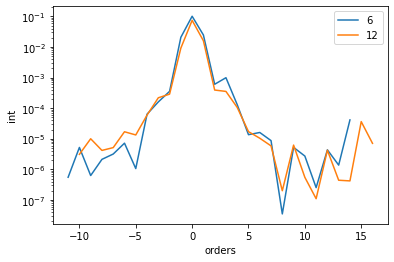

In [12]:
plt.plot(orders_all[0],fem_int_rough_all[0],label = '6')
plt.plot(orders_all[1],fem_int_rough_all[1],label = '12')
plt.yscale('log')
plt.xlabel('orders')
plt.ylabel('int')
plt.legend()
print(orders_all[0][11],fem_int_rough_all[0][11])
print(orders_all[1][10],fem_int_rough_all[1][10])
#13.500	6.0000	0.623964	0.00150510	0.24000 
#13.500	12.000	0.582878	0.00140600	0.24000 

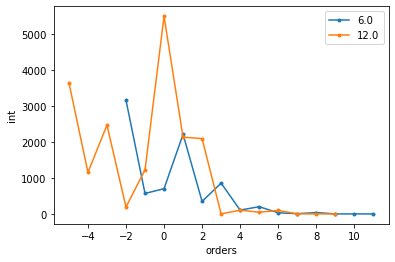

In [11]:
for n in range(len(keys['angles'])):
    exp_data_angle = str(keys['angles'][n][0])
#plt.plot(orders_all[0][x_exp],fem_int_rough_all[0][x_exp],'.-',label='JCM calc')
    plt.plot(exp_data[exp_data_angle][0],chi_all[n],'.-',label = exp_data_angle)
#plt.plot(exp_data['12.0'][0],chi_all[1],'.-',label = '12')
#plt.yscale('log')
plt.xlabel('orders')
plt.ylabel('int')
plt.legend()